In [4]:
import os, sys
import torch
sys.path.append("..")

MODEL_HOME = "~/YOLO_MODELS"
save_dir = os.path.expanduser(MODEL_HOME)
checkpoint_pth = save_dir + "/" + max([f for f in os.listdir(save_dir) if f.endswith(".pth")])

In [5]:
from models import YOLOv1
from data.VOC_Dataset import VOC_Dataset
from common_utils import DATA_HOME

from ipdb import set_trace
from torch.utils.data import DataLoader
from numpy import array
from multiprocessing import cpu_count
import random 
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

random.seed(1)
torch.manual_seed(1)

In [6]:
import platform

_voc_root = f"{DATA_HOME}/VOCdevkit/VOC2007"
voc_ds = VOC_Dataset(_voc_root)
BS = 1
class_dict =  {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}
class_dict = {v:k for k, v in class_dict.items()}

def collate_fn(data):
    # output: 7 * 7 * 30
    # S * S * ((x, y, w, h, confidence) * B=2 + C=20)
    # make img batch and label batch
    imgs, labels, classes = zip(*data)
    # inhomegenous shape label, since each image has different number of objects
    # label's dimension: (Batch size, # of objects in each image, 4 coords)
    return torch.tensor(array(imgs), dtype=torch.float), labels, classes
    
if platform.system() == "Windows":
    loader = DataLoader(voc_ds, batch_size=BS, pin_memory=True, shuffle=True, collate_fn=collate_fn)
else:
    loader = DataLoader(voc_ds, batch_size=BS, pin_memory=True, shuffle=True, num_workers=4, collate_fn=collate_fn)

class dict:  {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}


In [7]:
yolo = YOLOv1().to(device=device)
yolo.load_state_dict(torch.load(checkpoint_pth)["model"])
# set_trace()
S = 7 # num of rows/cols
C = 20 # num of classes
B = 2 # num of bounding boxes

C:\Users\sxing\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\sxing\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from utils.display import display_image_bbox
from utils.metrics import xywh_2_xxyy, IOU
import numpy as np

with torch.no_grad():
    for _, (batch, labels, classes) in enumerate(loader):
        res = yolo(batch.to(device=device)).squeeze(0)
        # set_trace()
        boxes = []
        labels_map = {}
        for i in range(res.shape[1]):
            for j in range(res.shape[2]):
                cell1 = res[:, i, j][:5]
                cell2 = res[:, i, j][5:10]
                boxes.append(cell1.detach().cpu().numpy())
                boxes.append(cell2.detach().cpu().numpy())
                labels_map[(i, j)] = res[:, i, j][-20:]

        # non-max suppression
        lo = 0
        while lo < len(boxes):
            del_inds = set()
            for j in range(lo+1, len(boxes)):
                if IOU(boxes[lo], boxes[j]) > 0.1:
                    if boxes[lo][4] > boxes[j][4]:
                        del_inds.add(j)
                    else:
                        del_inds.add(lo)
            boxes = np.delete(boxes, list(del_inds), axis=0)
            if lo in del_inds:
                lo = 0
            else:
                lo += 1
        
        # assign labels
        titles = []
        for x, y, _, _, _ in boxes:
            x_ind, y_ind = min(6, int(x * 7)), min(6, int(y * 7))
            class_arr = labels_map[(x_ind, y_ind)]
            _, max_class = max((value, index) for index, value in enumerate(class_arr))
            titles.append(class_dict[max_class])
        boxes = list(map(xywh_2_xxyy, boxes))
        
        # display prediction
        display_image_bbox(batch[0], boxes, titles)

        # display labels
        y_classes = [class_dict[c] for c in classes[0]]
        labels[0] = list(map(xywh_2_xxyy, labels[0]))
        display_image_bbox(batch[0], labels[0], y_classes)
        # break
        # set_trace()

loss_df:              l1         l2        l3         l4         l5
0     5.194468   9.110870  1.598770  22.738049  35.043690
1     0.081230   1.170098  0.153270  23.980816   9.991623
2     1.841111   2.562921  0.649430  23.485521  20.020388
3     6.753994  12.340377  2.525176  21.233906  64.976990
4     9.798468  11.062632  2.606509  20.981415  69.978523
...        ...        ...       ...        ...        ...
3000  0.994081   3.270579  0.898400   0.069623   9.667988
3001  0.747441   3.053672  0.225111   0.083453   5.560590
3002  0.220770   0.796573  0.417168   0.064758   3.795160
3003  0.342235   0.649725  0.298589   0.068869   6.759924
3004  0.166230   3.712342  0.288961   0.089758   5.805979

[3005 rows x 5 columns]


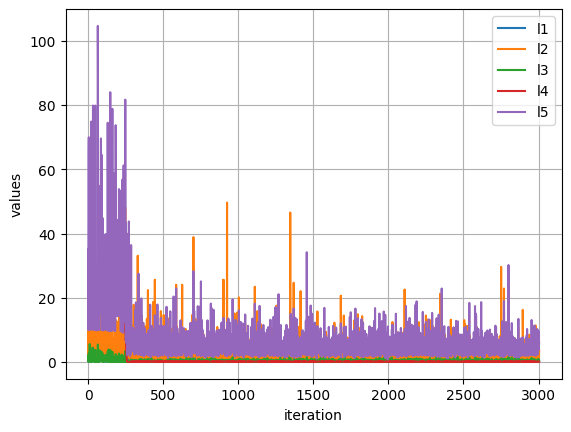

loss_df:              l1         l2        l3         l4         l5
0     0.712116   2.022540  0.405468  23.237299  24.997810
1     7.840194  14.275968  1.749699  22.980583  29.998144
2     0.888127   2.929377  0.452092  23.478292  19.975185
3     0.194858   0.521101  0.010276  23.980915   9.998253
4     5.527581   2.784665  1.403216  22.969875  29.981266
...        ...        ...       ...        ...        ...
3000  0.944063   8.835615  0.197187   0.133863  10.853124
3001  0.125345   2.746005  0.041219   0.097430   3.736184
3002  0.267642   3.648317  0.197126   0.104821   4.140882
3003  0.373598   4.589043  0.039294   0.161726   5.687270
3004  0.003628   2.065275  0.091060   0.194138   1.927893

[3005 rows x 5 columns]


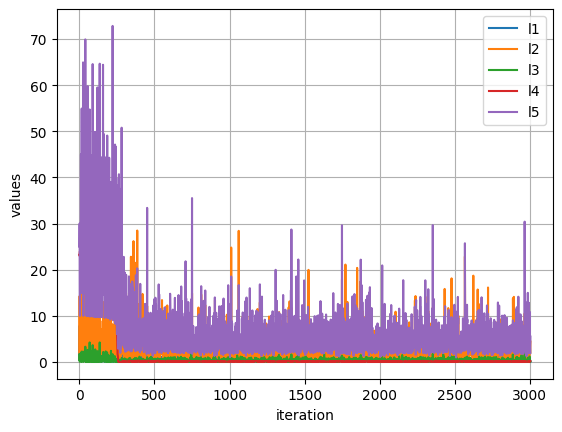

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
loss_dir = os.path.expanduser(save_dir)
for fname in ["/train_loss_latest.csv", "/val_loss_latest.csv"]:
    loss_df = pd.read_csv(loss_dir + fname, index_col=0)
    print("loss_df: ", loss_df)
    for col in loss_df.columns:
        # if col == "l1" or col == "l2": #or col == "l5":
        plt.plot(loss_df[col], label=col)
    plt.xlabel("iteration")
    plt.ylabel("values")
    plt.legend()
    plt.grid(True)
    plt.show()